http://openmonkeychallenge.com/index.html

### Imports

In [ ]:
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Reading 

import os
from glob import glob
from PIL import Image

# TQDM es útil para calcular el progreso de una operación
from tqdm.auto import tqdm

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from scipy.stats import zscore

import seaborn as sns
sns.set_style('darkgrid')

import json


import shutil
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
# import albumentations as A

from skimage import io
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from numpy import asarray
import math
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

import plotly.express as px

#Pytorch utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


### Helper functions

In [ ]:
# Just returns accuracy on test data
def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

### Running in Colab using Kaggle

In [ ]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !pip install opendatasets
# import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ## correr la celda e ingresar nombre de usuario de Kaggle y Kaggle Key
# link_comp = "https://www.kaggle.com/datasets/danielchang2002/openmonkeychallenge"
# od.download(link_comp)

# ## Kaggle username: brunobustos
# ## Kaggle Key: 3c51b2a55e01bf723043581a8037459c

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: brunobustos
Your Kaggle Key: ··········


100%|██████████| 12.1G/12.1G [01:54<00:00, 114MB/s]


### Loading the data for training, validation and test

In [ ]:
#Opening the dataset and explore the json

f = open('openmonkeychallenge/train_annotation.json')
json_train = json.load(f)

id=random.randint(0, len(json_train['data']))
print(json_train['data'][id].keys())

print(json_train['data'][id])
print(len(json_train['data']))

dict_keys(['file', 'species', 'bbox', 'landmarks', 'visibility'])
{'file': 'train_0052980.jpg', 'species': 'Vervet_monkey', 'bbox': [15, 10, 364, 489], 'landmarks': [216, 140, 234, 118, 235, 143, 188, 80, 221, 175, 200, 172, 231, 243, 250, 148, 284, 127, 309, 146, 281, 159, 124, 331, 186, 243, 256, 315, 256, 351, 257, 464, 85, 495], 'visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
66917


In [ ]:
f = open('openmonkeychallenge/train_annotation.json')
json_train_specie = json.load(f)
print(len(json_train_specie['data']))

#go through all the data and if the specie does not match the chosen one is deleted 
for id in range(len(json_train['data'])):
  id = len(json_train['data'])-1 - id
  specie = json_train['data'][id]['species']

  if specie != 'Japanese_macaque':
    try:
      del json_train_specie['data'][id]
    except:
      print(id)

print(len(json_train_specie['data']))

66917
29424


In [ ]:
f = open('openmonkeychallenge/val_annotation.json')
json_val = json.load(f)

id=random.randint(0, len(json_val['data']))
print(json_val['data'][id].keys())

print(json_val['data'][id])
print(len(json_val['data']))

dict_keys(['file', 'species', 'bbox', 'landmarks', 'visibility'])
{'file': 'val_0020635.jpg', 'species': 'Rhesus_macaque', 'bbox': [72, 111, 833, 557], 'landmarks': [819, 261, 833, 261, 835, 286, 833, 194, 744, 272, 705, 332, 608, 436, 634, 583, 711, 308, 650, 390, 708, 575, 283, 181, 334, 432, 268, 598, 275, 423, 194, 503, 142, 470], 'visibility': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
22306


In [ ]:
f = open('openmonkeychallenge/val_annotation.json')
json_val_specie = json.load(f)
print(len(json_val_specie['data']))

#go through all the data and if the specie does not match the chosen one is deleted 
for id in range(len(json_val['data'])):
  id = len(json_val['data']) - 1 - id
  specie = json_val['data'][id]['species']

  if specie != 'Japanese_macaque':
    try:
      del json_val_specie['data'][id]
    except:
      print(id)

print(len(json_val_specie['data']))

22306
9852


### Test Dataset

In [ ]:
f = open('openmonkeychallenge/test_prediction.json')
json_test = json.load(f)

f = open('openmonkeychallenge/test_prediction.json')
json_test_specie = json.load(f)
print(len(json_test_specie['data']))

# #go through all the data and if the specie does not match the chosen one is deleted 
for id in range(len(json_test['data'])):
  id = len(json_test['data']) - 1 - id
  specie = json_test['data'][id]['species']

  if specie != 'Japanese_macaque':
    try:
      del json_test_specie['data'][id]
    except:
      print(id)

print(len(json_test_specie['data']))

22306
9921


### Plotting some graphs

(607, 1080, 3)


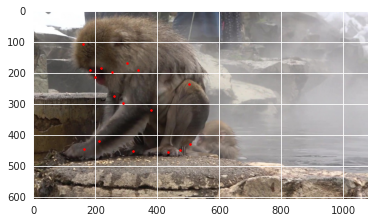

In [ ]:
keypoints=json_train['data'][id]['landmarks']

landmarks = torch.tensor(keypoints).float().reshape(-1, 2)
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    image=np.array(image)
    if image.shape[0]==3:
      image=np.moveaxis(image*255, 0, -1)
      image=image.astype(np.uint8)
    print(image.shape)
    plt.imshow(image)

    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('openmonkeychallenge/train/train/%s' %json_train['data'][id]['file'])),
               landmarks)
plt.show()

### Exploring the dataset

In [ ]:
for_specie = True
if for_specie == True:
  json_train = json_train_specie


landmarks_train=[]
filenames_train=[]
#comentar
for i in range(0,len(json_train['data'])):
  keypoints_rel=json_train['data'][i]['landmarks']
  filenames=json_train['data'][i]['file']
  landmarks_train.append(keypoints_rel)
  filenames_train.append(filenames)

print(landmarks_train[0])
print(filenames_train[0])

[183, 190, 218, 185, 200, 214, 161, 107, 303, 170, 253, 198, 261, 276, 213, 420, 338, 192, 380, 320, 165, 445, 506, 429, 291, 297, 321, 451, 503, 235, 434, 456, 473, 450]
train_0000000.jpg


In [ ]:
if for_specie == True:
  json_val = json_val_specie
  
landmarks_val=[]
filenames_val=[]
#comentar
for i in range(0,len(json_val['data'])):
  keypoints_rel=json_val['data'][i]['landmarks']
  filenames=json_val['data'][i]['file']
  landmarks_val.append(keypoints_rel)
  filenames_val.append(filenames)

print(landmarks_val[0])
print(filenames_val[0])

[516, 442, 515, 445, 505, 465, 525, 387, 547, 494, 497, 515, 483, 573, 501, 673, 643, 472, 709, 536, 733, 486, 678, 605, 538, 584, 553, 656, 625, 556, 580, 650, 616, 707]
val_0000001.jpg


### Creacion de dataset:
Referencia: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
# define a dataset class to load the data

def heatmap2image(hm, cmap='jet', colors=None):
  """
  heatmap2image(hm,cmap='jet',colors=None)
  Creates and returns an image visualization from landmark heatmaps. Each
  landmark is colored according to the input cmap/colors.
  Inputs:
    hm: nlandmarks x height x width ndarray, dtype=float in the range 0 to 1.
    hm[p,i,j] is a score indicating how likely it is that the pth landmark
    is at pixel location (i,j).
    cmap: string.
    Name of colormap for defining colors of landmark points. Used only if colors
    is None.
    Default: 'jet'
    colors: list of length nlandmarks.
    colors[p] is an ndarray of size (4,) indicating the color to use for the
    pth landmark. colors is the output of matplotlib's colormap functions.
    Default: None
  Output:
    im: height x width x 3 ndarray
    Image representation of the input heatmap landmarks.
  """
  hm = np.maximum(0., np.minimum(1. ,hm))
  im = np.zeros((hm.shape[1], hm.shape[2], 3))
  # if colors is None:
  #   if isinstance(cmap, str):
  #     cmap = matplotlib.cm.get_cmap(cmap)
  #   colornorm = matplotlib.colors.Normalize(vmin=0, vmax=hm.shape[0])
  #   colors = cmap(colornorm(np.arange(hm.shape[0])))
  # for i in range(hm.shape[0]):
  #   color = colors[i]
  #   for c in range(3):
  #     im[..., c] = im[..., c] + (color[c] * .7 + .3) * hm[i, ...]
  # im = np.minimum(1.,im)

  if colors is None:
    if isinstance(cmap, str):
      cmap = matplotlib.cm.get_cmap(cmap)
    colornorm = matplotlib.colors.Normalize(vmin=0, vmax=hm.shape[0])
    colors = cmap(colornorm(np.arange(hm.shape[0])))
  for i in range(hm.shape[0]):
    color = colors[i]
    for c in range(3):
      im[..., c] = im[..., c] + (color[c] * .7 + .3) * np.array(hm[i, ...])
  im = np.minimum(1.,im)

  return im


class LandmarksDataset(Dataset):
    """Landmarks dataset."""

    def __init__(self, landmarks, filenames,root_dir, label_sigma=3., transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame =landmarks
        self.filenames_frame=filenames
        self.root_dir = root_dir
        self.transform_frame = transform

        # output will be heatmap images, one per landmark, with Gaussian values
        # around the landmark location -- precompute some stuff for that
        self.label_filter = None
        self.label_filter_r = 1
        self.label_filter_d = 3
        self.label_sigma = label_sigma
        self.init_label_filter()


    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.filenames_frame[idx])
        # image = io.imread(img_name, as_gray=True)
        image = io.imread(img_name)

        h, w = image.shape[:2]

        landmarks = self.landmarks_frame[idx]
        landmarks=np.array(landmarks)
        landmarks = landmarks.astype('float').reshape(-1, 2)
        #landmarks = torch.tensor(landmarks).float().reshape(-1, 2)

        if self.transform_frame:
            image = self.transform_frame(image)


        new_w=image.size(dim=1)
        landmarks = landmarks * [new_w / w, new_w / h]
        
        imsz = torch.ones([128, 128]).shape
        # print(landmarks.shape, imsz)
        heatmaps = self.make_heatmap_target(landmarks, imsz)
        
        sample = {'image': image, 'landmarks': landmarks, 'heatmaps':heatmaps, 'id' : idx}


        return sample

    def init_label_filter(self):
      """
      init_label_filter(self)
      Helper function
      Create a Gaussian filter for the heatmap target output
      """
      # radius of the filter
      self.label_filter_r = max(int(round(3 * self.label_sigma)), 1)
      # diameter of the filter
      self.label_filter_d = 2 * self.label_filter_r + 1

      # allocate
      self.label_filter = np.zeros([self.label_filter_d, self.label_filter_d])
      # set the middle pixel to 1.
      self.label_filter[self.label_filter_r, self.label_filter_r] = 1.
      # blur with a Gaussian
      self.label_filter = cv2.GaussianBlur(self.label_filter,
                                          (self.label_filter_d,
                                            self.label_filter_d),
                                          self.label_sigma)
      # normalize
      self.label_filter = self.label_filter / np.max(self.label_filter)
      # convert to torch tensor
      self.label_filter = torch.from_numpy(self.label_filter)


    def make_heatmap_target(self, locs, imsz):
      """
      make_heatmap_target(self,locs,imsz):
      Helper function
      Creates the heatmap tensor of size imsz corresponding to landmark locations locs
      Inputs:
        locs: nlandmarks x 2 ndarray
        Locations of landmarks
        imsz: image shape
      Returns:
        target: torch tensor of size nlandmarks x imsz[0] x imsz[1]
        Heatmaps corresponding to locs
      """
      # allocate the tensor
      target = torch.zeros((locs.shape[0], imsz[0], imsz[1]), dtype=torch.float32)
      # loop through landmarks
      for i in range(locs.shape[0]):
        # location of this landmark to the nearest pixel
        x = int(np.round(locs[i, 0])) # losing sub-pixel accuracy
        y = int(np.round(locs[i, 1]))
        # edges of the Gaussian filter to place, minding border of image
        x0 = np.maximum(0, x - self.label_filter_r)
        x1 = np.minimum(imsz[1] - 1, x + self.label_filter_r)
        y0 = np.maximum(0, y - self.label_filter_r)
        y1 = np.minimum(imsz[0] - 1, y + self.label_filter_r)

        if x0-x1 != 18:
          if x0 == 0:
            x1 = x0+18
          else:
            x0 = x1-18
        if y0-y1 != 18:
          if y0 == 0:
            y1 = y0+18
          else:
            y0 = y1-18

        # crop filter if it goes outside of the image
        fil_x0 = self.label_filter_r - (x - x0)
        fil_x1 = self.label_filter_d - (self.label_filter_r - (x1 - x))
        fil_y0 = self.label_filter_r - (y - y0)
        fil_y1 = self.label_filter_d - (self.label_filter_r - (y1 - y))
        # copy the filter to the relevant part of the heatmap image
        #CHECK THIS CODE CUZ THERE A LOT OF ERRORS
        #THE PROBLEM IS THAT IN SOME POINT INSTEAD OF 20 THERE ARE 16 
        #IN THE VALUE OF fil_x0 IF I RECALL
        try:
          target[i, y0:y1 + 1, x0:x1 + 1] = self.label_filter[fil_y0:fil_y1 + 1,
                                                    fil_x0:fil_x1 + 1]
          # print(self.label_filter[fil_y0:fil_y1 + 1,fil_x0:fil_x1 + 1])
        except:
          # print('ERRRRRORRR')
          pass
      return target


    @staticmethod
    def get_image(d, i=None):
      """
      static function, used for visualization
      COCODataset.get_image(d,i=None)
      Returns an image usable with plt.imshow()
      Inputs:
        d: if i is None, item from a COCODataset.
        if i is a scalar, batch of examples from a COCO Dataset returned
        by a DataLoader.
        i: Index of example into the batch d, or None if d is a single example
      Returns the ith image from the patch as an ndarray plottable with
      plt.imshow()
      """
      #CHECK THIS FUNCTION LATER
      # if i is None:
      #   im = np.squeeze(np.transpose(d['image'].numpy(), (1, 2, 0)), axis=2)
      # else:
      #   im = np.squeeze(np.transpose(d['image'][i,...].numpy(), (1, 2, 0)), axis=2)
      return d['image'][i,...]

    @staticmethod
    def get_landmarks(d, i=None):
      """
      static helper function
      COCODataset.get_landmarks(d,i=None)
      Returns a nlandmarks x 2 ndarray indicating landmark locations.
      Inputs:
        d: if i is None, item from a COCODataset.
        if i is a scalar, batch of examples from a COCO Dataset returned
        by a DataLoader.
        i: Index of example into the batch d, or None if d is a single example
      """
      if i is None:
        locs = d['landmarks']
      else:
        locs = d['landmarks'][i]
      return locs


    @staticmethod
    def get_heatmap_image(d, i, cmap='jet', colors=None):
      """
      static function, used for visualization
      COCODataset.get_heatmap_image(d,i=None)
      Returns an image visualization of heatmaps usable with plt.imshow()
      Inputs:
        d: if i is None, item from a COCODataset.
        if i is a scalar, batch of examples from a COCO Dataset returned
        by a DataLoader.
        i: Index of example into the batch d, or None if d is a single example
        Returns the ith heatmap from the patch as an ndarray plottable with
        plt.imshow()
        cmap: string.
        Name of colormap for defining colors of landmark points. Used only if colors
        is None.
        Default: 'jet'
        colors: list of length nlandmarks.
        colors[p] is an ndarray of size (4,) indicating the color to use for the
        pth landmark. colors is the output of matplotlib's colormap functions.
        Default: None
      Output:
        im: height x width x 3 ndarray
        Image representation of the input heatmap landmarks.
      """
      if i is None:
        hm = d['heatmaps']
      else:
        hm = d['heatmaps'][i, ...]
      hm = hm.numpy()
      im = heatmap2image(hm, cmap=cmap, colors=colors)

      return im

In [ ]:


# dataset_train = LandmarksDataset(landmarks=landmarks_train,root_dir='openmonkeychallenge/train/train/',
#                                  filenames=filenames_train,  transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128)), transforms.RandomRotation(10), 
#                                                                                            transforms.RandomInvert(p=0.1), transforms.Grayscale(1), transforms.RandomHorizontalFlip()]))


dataset_train = LandmarksDataset(landmarks=landmarks_train,root_dir='openmonkeychallenge/train/train/',
                                 filenames=filenames_train,  transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))]))

dataset_val = LandmarksDataset(landmarks=landmarks_val,root_dir='openmonkeychallenge/val/val/',
                               filenames=filenames_val,transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))]))




0 torch.Size([8, 3, 128, 128]) torch.Size([8, 17, 2]) torch.Size([8, 17, 128, 128])


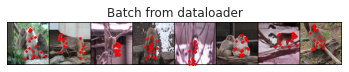

1 torch.Size([8, 3, 128, 128]) torch.Size([8, 17, 2]) torch.Size([8, 17, 128, 128])


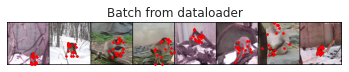

2 torch.Size([8, 3, 128, 128]) torch.Size([8, 17, 2]) torch.Size([8, 17, 128, 128])


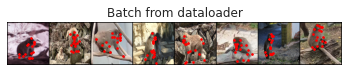

3 torch.Size([8, 3, 128, 128]) torch.Size([8, 17, 2]) torch.Size([8, 17, 128, 128])


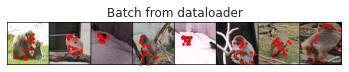

4 torch.Size([8, 3, 128, 128]) torch.Size([8, 17, 2]) torch.Size([8, 17, 128, 128])


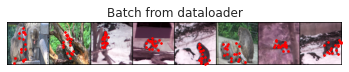

5 torch.Size([8, 3, 128, 128]) torch.Size([8, 17, 2]) torch.Size([8, 17, 128, 128])


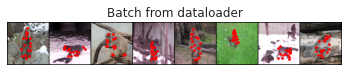

In [ ]:
num_workers=10

dataloader_train = DataLoader(dataset_train, batch_size=8,
                        shuffle=True, num_workers=num_workers)

dataloader_val = DataLoader(dataset_val, batch_size=8,
                        shuffle=True, num_workers=num_workers)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader_train):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size(),sample_batched['heatmaps'].size())
    
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()


    # observe 4th batch and stop.
    if i_batch == 5:
        break


torch.Size([17, 128, 128])


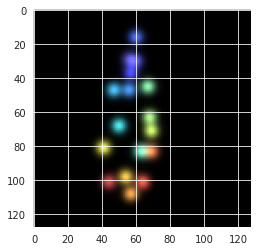

In [ ]:
plt.imshow(heatmap2image(sample_batched['heatmaps'][0]))
print(sample_batched['heatmaps'][0].shape)

In [ ]:
def show_landmarks_hmim(image, landmarks,heatmap):
    """Show image with landmarks"""
    image=np.array(image)
    if image.shape[0]==3:
      image=np.moveaxis(image*255, 0, -1)
      image=image.astype(np.uint8)

    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
      
    # showing image
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
      
    # Adds a subplot at the 2nd position
    fig.add_subplot(1, 2, 2)

    plt.imshow(heatmap)

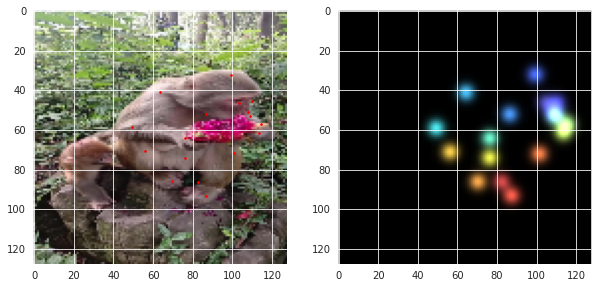

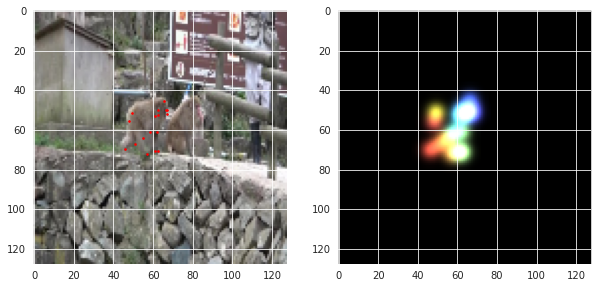

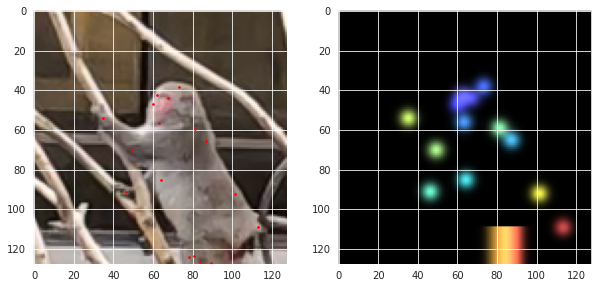

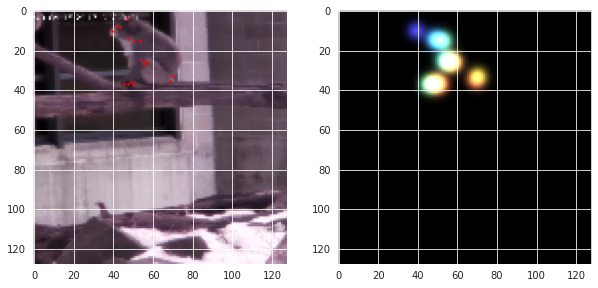

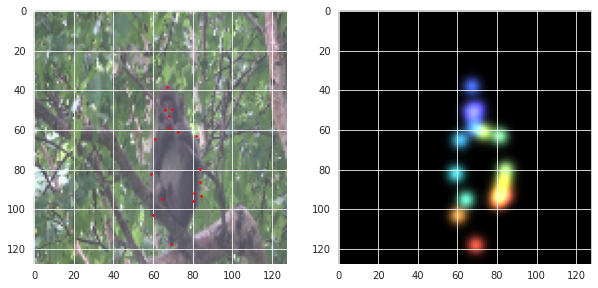

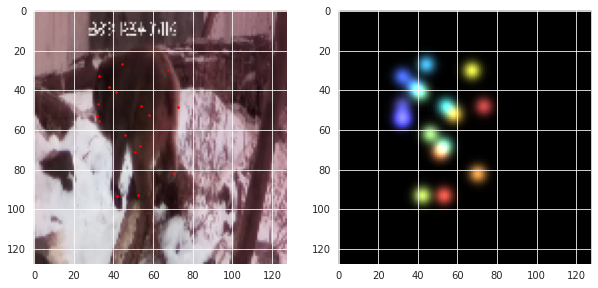

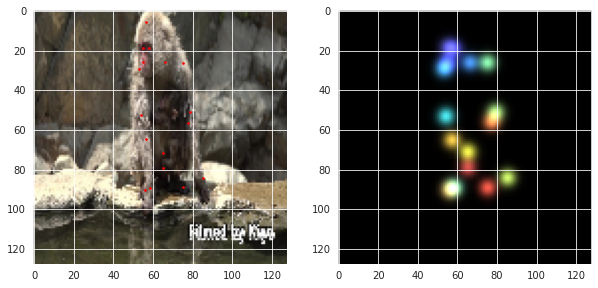

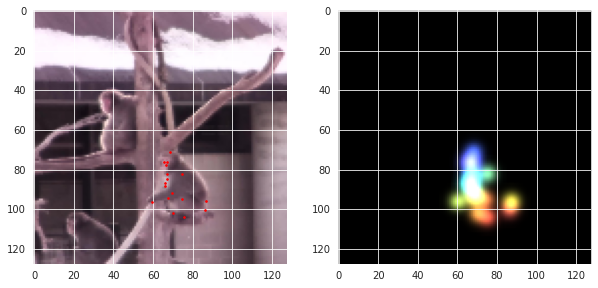

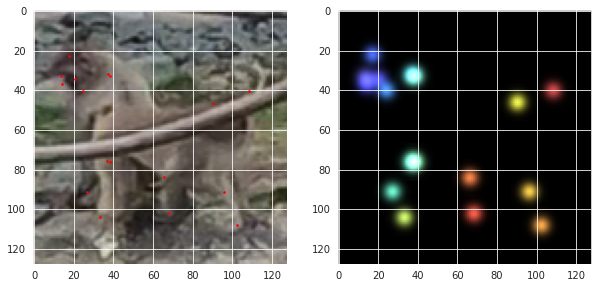

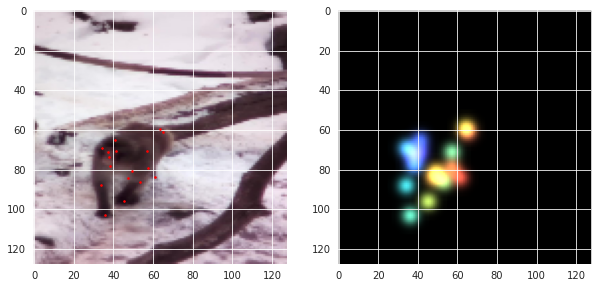

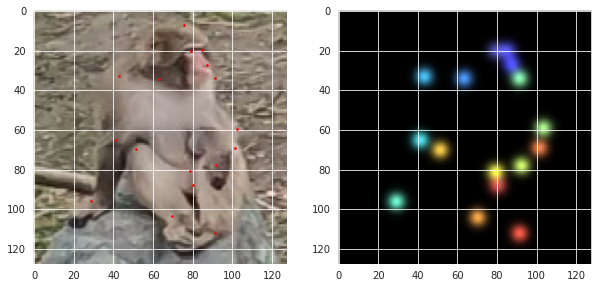

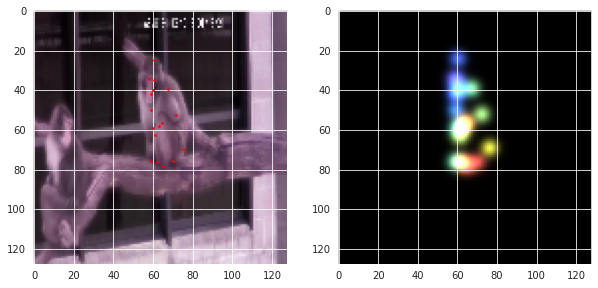

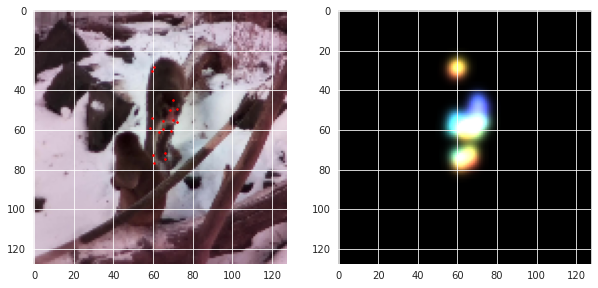

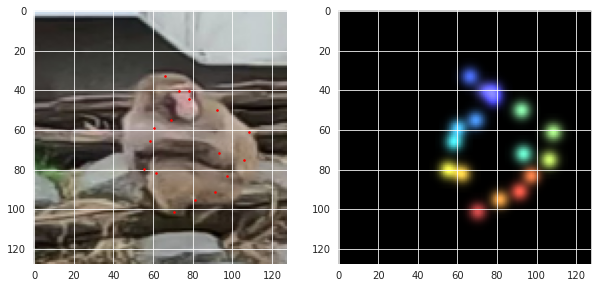

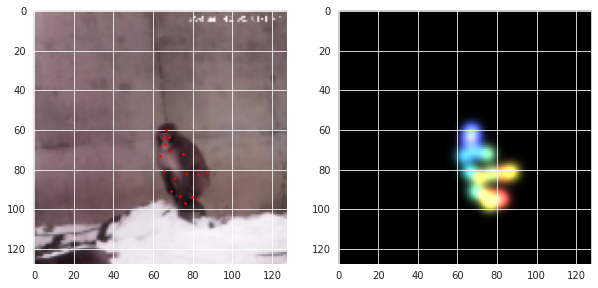

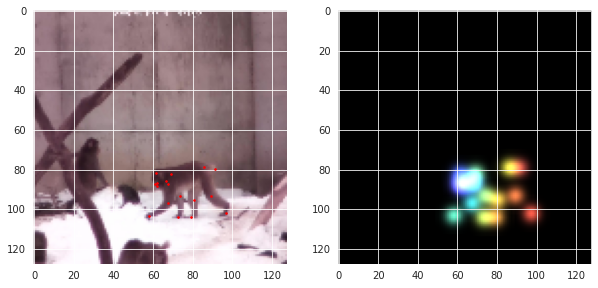

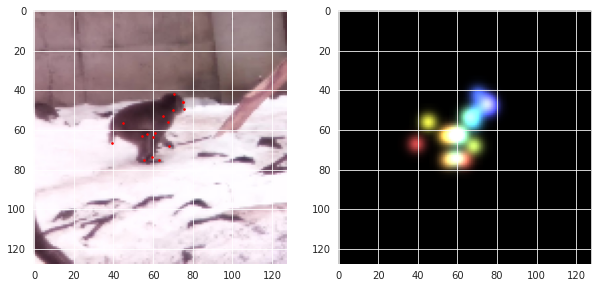

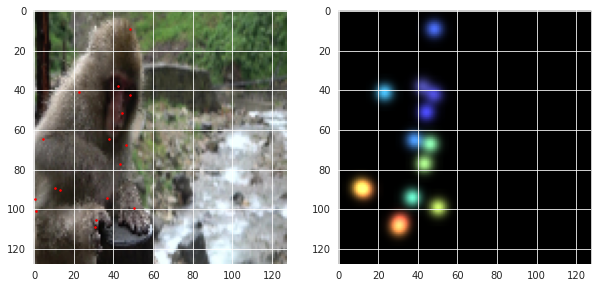

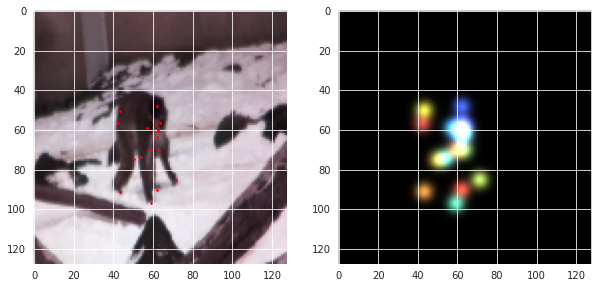

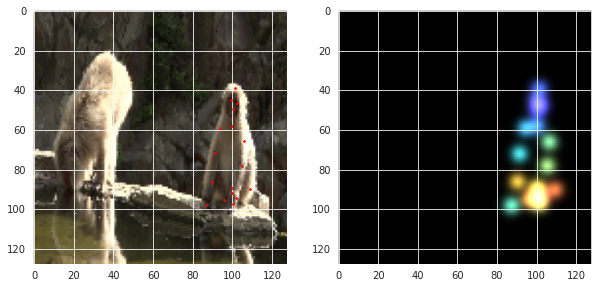

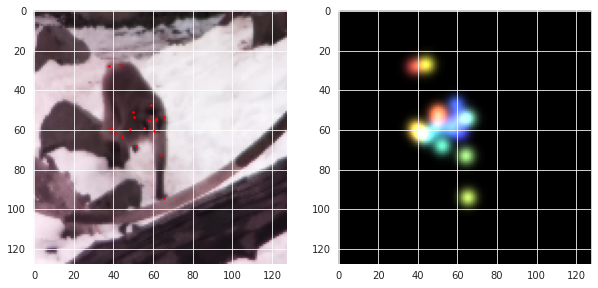

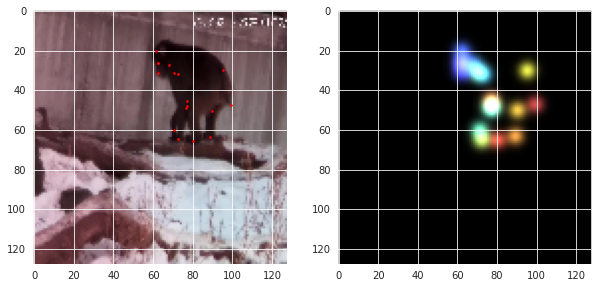

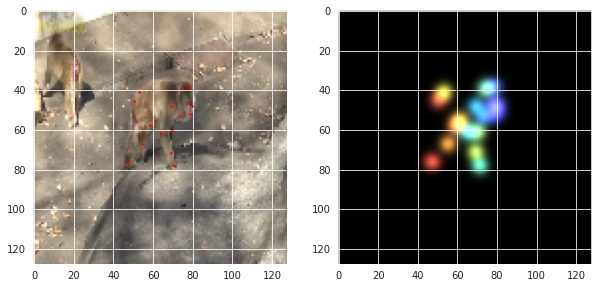

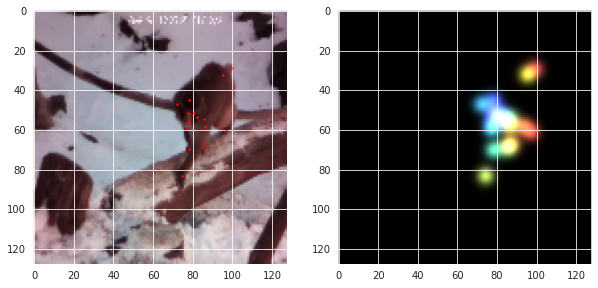

In [ ]:
for i_batch, sample_batched in enumerate(dataloader_train):

  for j in range(len(sample_batched['image'])):
    # print(sample_batch, j)
    im = LandmarksDataset.get_image(sample_batched, j)
    locs = LandmarksDataset.get_landmarks(sample_batched, j)
    hmim = LandmarksDataset.get_heatmap_image(sample_batched, j)
    show_landmarks_hmim(im,locs,hmim)
    plt.show()
  # observe 4th batch and stop.
  if i_batch == 2:
      break
# show_landmarks(im,locs)

### new architecture

### W -Net TODO 

### Architectures

In [ ]:
# Define network structure - UNet
# Copy-paste & modify from https://github.com/milesial/Pytorch-UNet

# The UNet is defined modularly.
# It is a series of downsampling layers defined by the module Down
# followed by upsampling layers defined by the module Up. The output is
# a convolutional layer with an output channel for each landmark, defined by
# the module OutConv.
# Each down and up layer is actually two convolutional layers with
# a ReLU nonlinearity and batch normalization, defined by the module
# DoubleConv.
# The Down module consists of a 2x2 max pool layer followed by the DoubleConv
# module.
# The Up module consists of an upsampling, either defined via bilinear
# interpolation (bilinear=True), or a learned convolutional transpose, followed
# by a DoubleConv module.
# The Output layer is a single 2-D convolutional layer with no nonlinearity.
# The nonlinearity is incorporated into the network loss function.

class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
        mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return self.double_conv(x)


class Down(nn.Module):
  """Downscaling with maxpool then double conv"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
        )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  """Upscaling then double conv"""

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)


  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

# copy-pasted and modified from unet_model.py

class UNet(nn.Module):
  def __init__(self, n_channels, n_landmarks, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_landmarks = n_landmarks
    self.bilinear = bilinear
    self.nchannels_inc = 64

    # define the layers

    #one more than emilio
    # number of channels in the first layer
    nchannels_inc = self.nchannels_inc
    # increase the number of channels by a factor of 2 each layer
    nchannels_down1 = nchannels_inc*2
    nchannels_down2 = nchannels_down1*2
    nchannels_down3 = nchannels_down2*2
    nchannels_down4 = nchannels_down3*2
    nchannels_down5 = nchannels_down4*2
    # decrease the number of channels by a factor of 2 each layer
    nchannels_up1 = nchannels_down5//2
    nchannels_up2 = nchannels_up1//2
    nchannels_up3 = nchannels_up2//2
    nchannels_up4 = nchannels_up3//2
    nchannels_up5 = nchannels_up4//2

    if bilinear:
      factor = 2
    else:
      factor = 1

    self.layer_inc = DoubleConv(n_channels, nchannels_inc)

    self.layer_down1 = Down(nchannels_inc, nchannels_down1)
    self.layer_down2 = Down(nchannels_down1, nchannels_down2)
    self.layer_down3 = Down(nchannels_down2, nchannels_down3)
    self.layer_down4 = Down(nchannels_down3, nchannels_down4)
    self.layer_down5 = Down(nchannels_down4, nchannels_down5//factor)

    self.layer_up1 = Up(nchannels_down5, nchannels_up1//factor, bilinear)
    self.layer_up2 = Up(nchannels_up1, nchannels_up2//factor, bilinear)
    self.layer_up3 = Up(nchannels_up2, nchannels_up3//factor, bilinear)
    self.layer_up4 = Up(nchannels_up3, nchannels_up4//factor, bilinear)
    self.layer_up5 = Up(nchannels_up4, nchannels_up5//factor, bilinear)
    self.layer_outc = OutConv(nchannels_up5//factor, self.n_landmarks)

  def forward(self, x, verbose=False):
    x1 = self.layer_inc(x)
    if verbose: print(f'inc: shape = {x1.shape}')
    x2 = self.layer_down1(x1)
    if verbose:print(f'inc: shape = {x2.shape}')
    x3 = self.layer_down2(x2)
    if verbose: print(f'inc: shape = {x3.shape}')
    x4 = self.layer_down3(x3)
    if verbose: print(f'inc: shape = {x4.shape}')
    x5 = self.layer_down4(x4)
    if verbose: print(f'inc: shape = {x5.shape}')
    x6 = self.layer_down5(x5)
    if verbose: print(f'inc: shape = {x6.shape}')
    x = self.layer_up1(x6, x5)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up2(x, x4)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up3(x, x3)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up4(x, x2)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up5(x, x1)
    if verbose: print(f'inc: shape = {x.shape}')
    logits = self.layer_outc(x)
    if verbose: print(f'outc: shape = {logits.shape}')

    return logits

  def output(self, x, verbose=False):
    return torch.sigmoid(self.forward(x, verbose=verbose))

  def __str__(self):
    s = ''
    s += 'inc: '+str(self.layer_inc)+'\n'
    s += 'down1: '+str(self.layer_down1)+'\n'
    s += 'down2: '+str(self.layer_down2)+'\n'
    s += 'down3: '+str(self.layer_down3)+'\n'
    s += 'down4: '+str(self.layer_down4)+'\n'
    s += 'down5: '+str(self.layer_down5)+'\n'
    s += 'up1: '+str(self.layer_up1)+'\n'
    s += 'up2: '+str(self.layer_up2)+'\n'
    s += 'up3: '+str(self.layer_up3)+'\n'
    s += 'up4: '+str(self.layer_up4)+'\n'
    s += 'up5: '+str(self.layer_up5)+'\n'
    s += 'outc: '+str(self.layer_outc)+'\n'
    return s

  def __repr__(self):
    return str(self)


def heatmap2landmarks(hms):
  idx = np.argmax(hms.reshape(hms.shape[:-2] + (hms.shape[-2]*hms.shape[-1], )),
                  axis=-1)
  locs = np.zeros(hms.shape[:-2] + (2, ))
  locs[...,1],locs[...,0] = np.unravel_index(idx,hms.shape[-2:])
  return locs

In [ ]:
# Instantiate the network
net = UNet(n_channels=3, n_landmarks=17)
net.to(device=DEVICE) # have to be careful about what is done on the CPU vs GPU

# try the network out before training
batch = next(iter(dataloader_train))
print(batch['image'].shape)
with torch.no_grad():
  hms0 = net.output(batch['image'].to(device=DEVICE), verbose=True)

# fig = plt.figure(figsize=(12, 4*len(batch['id'])), dpi= 100)
print(hms0.shape)
# PlotLabelAndPrediction(batch, hms0)

torch.Size([8, 3, 128, 128])
inc: shape = torch.Size([8, 64, 128, 128])
inc: shape = torch.Size([8, 128, 64, 64])
inc: shape = torch.Size([8, 256, 32, 32])
inc: shape = torch.Size([8, 512, 16, 16])
inc: shape = torch.Size([8, 1024, 8, 8])
inc: shape = torch.Size([8, 1024, 4, 4])
inc: shape = torch.Size([8, 512, 8, 8])
inc: shape = torch.Size([8, 256, 16, 16])
inc: shape = torch.Size([8, 128, 32, 32])
inc: shape = torch.Size([8, 64, 64, 64])
inc: shape = torch.Size([8, 32, 128, 128])
outc: shape = torch.Size([8, 17, 128, 128])
torch.Size([8, 17, 128, 128])


torch.Size([3, 128, 128]) torch.Size([17, 2]) (128, 128, 3)
torch.Size([17, 128, 128])


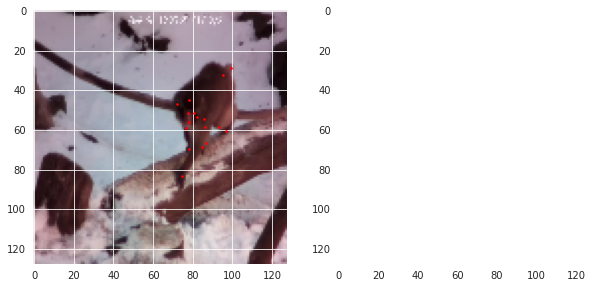

In [ ]:
print(im.shape,locs.shape,hmim.shape)
show_landmarks_hmim(im,locs,hmim)
plt.imshow(heatmap2image(hms0[0].cpu()))
print(hms0[0].shape)

### Old Training LOOP (deprecated)

In [ ]:
# savefile = '/content/drive/My Drive/PoseEstimationNets/UNet20210510T140305/Final_epoch4.pth'

# loadepoch = 10
# # savefile = None
# if savefile is not None:
#   net.load_state_dict(
#       torch.load(savefile, map_location=device)
#       )

#   net.to(device=device)

### New loss

In [ ]:
#https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/core/loss.py

def new_loss(output, target):
    criterion = nn.MSELoss(size_average=True)
    batch_size = output.size(0)
    num_joints = output.size(1)
    heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
    heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
    loss = 0

    for idx in range(num_joints):
        heatmap_pred = heatmaps_pred[idx].squeeze()
        heatmap_gt = heatmaps_gt[idx].squeeze()
        loss += 0.5 * criterion(heatmap_pred, heatmap_gt)

    return loss / num_joints

### NEW TRAINING LOOP

Random seed 2021 has been set.


  0%|          | 0/10 [00:00<?, ?epoch/s]

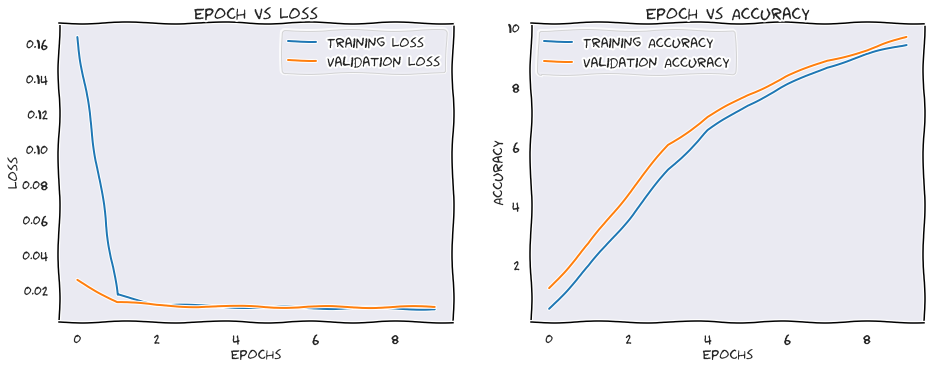

In [ ]:
def train(model, device, train_loader, validation_loader, epochs):
  """
  Training loop
  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set
  Returns:
    Nothing
  """
  criterion =  nn.BCEWithLogitsLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  optimizer = optim.Adam(net.parameters(),lr=0.0001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # Keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for batch in train_loader:
        imgs = batch['image']
        imgs = imgs.to(device=DEVICE, dtype=torch.float32) # transfer to GPU
        hm_labels = batch['heatmaps']
        hm_labels = hm_labels.to(device=DEVICE, dtype=torch.float32) # transfer to GPU
        data, target = imgs, hm_labels

        # COMPLETE CODE FOR TRAINING LOOP by following these steps
        # 1. Get the model output (call the model with the data from this batch)
        output = model(data)

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        optimizer.zero_grad()

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = criterion(output, target)

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        loss.backward()

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        optimizer.step()

        # Set loss to whatever you end up naming your variable when
        # calling criterion
        # For example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()  # Add the loss for this batch

        # Get accuracy
        # _, predicted = torch.max(output, 1)
        total += target.size(0)
        # correct += (predicted == target).sum().item()

        # new_loss(batch['heatmaps'],output.cpu())
        correct += new_loss(batch['heatmaps'],output.cpu()).detach().numpy()


      train_loss.append(running_loss / len(train_loader))  # Append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct / total)

      # Evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for batch in validation_loader:
        imgs = batch['image']
        imgs = imgs.to(device=DEVICE, dtype=torch.float32) # transfer to GPU
        hm_labels = batch['heatmaps']
        hm_labels = hm_labels.to(device=DEVICE, dtype=torch.float32) # transfer to GPU
        data, target = imgs, hm_labels
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # Get accuracy
        # _, predicted = torch.max(output, 1)
        total += target.size(0)
        # correct += (predicted == target).sum().item()
        correct += new_loss(batch['heatmaps'],output.cpu()).detach().numpy()



      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
# Instantiate the network


net = UNet(n_channels=3, n_landmarks=17).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, dataloader_train, dataloader_val, 20)

with plt.xkcd():
  plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

-

ksdf

In [ ]:

savedir = 'openmonkeychallenge'

# if the folder does not exist, create it.
if not os.path.exists(savedir):
  os.mkdir(savedir)

checkpointdir = os.path.join(savedir, 'UNet')
os.mkdir(checkpointdir)

torch.save(net.state_dict(),
           os.path.join(checkpointdir, f"Final_epoch.pth"))

In [ ]:
# print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

### OLD TESTING

In [ ]:
# try the trained network out on training and val images
net.eval()
batch = next(iter(dataloader_train))
with torch.no_grad():
  train_hms1 = torch.sigmoid(net(batch['image'].to(DEVICE)))

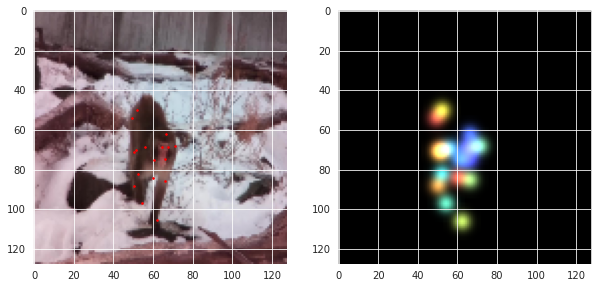

In [ ]:
j=2
im = LandmarksDataset.get_image(batch, j)
locs = LandmarksDataset.get_landmarks(batch, j)
hmim = LandmarksDataset.get_heatmap_image(batch, j)
show_landmarks_hmim(im,locs,hmim)

In [ ]:
# new_loss(batch['heatmaps'],train_hms1.cpu())

# # batch['heatmaps'].shape #torch.Size([4, 17, 256, 256])
# # train_hms1.cpu().shape #torch.Size([4, 17, 256, 256])

# # batch['heatmaps'][0].shape torch.Size([17, 256, 256])
# # train_hms1[1].cpu().shape #torch.Size([17, 256, 256])

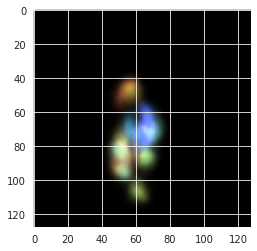

In [ ]:
plt.imshow(heatmap2image(train_hms1[j].cpu()))

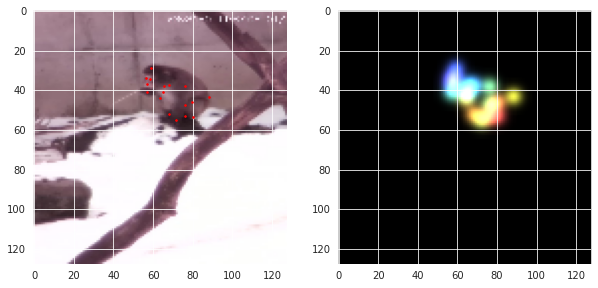

In [ ]:
# plt.imshow(batch['image'][3])
j=0
im = LandmarksDataset.get_image(batch, j)
locs = LandmarksDataset.get_landmarks(batch, j)
hmim = LandmarksDataset.get_heatmap_image(batch, j)
show_landmarks_hmim(im,locs,hmim)

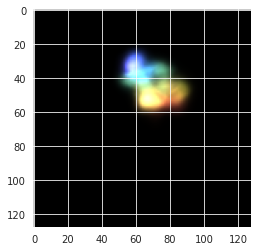

In [ ]:
plt.imshow(heatmap2image(train_hms1[0].cpu()))
# print(train_hms1.shape)

### EEvaluate the training and validation error

In [ ]:
# Evaluate the training and validation error

def eval_net(net, loader):
  net.eval()
  n_val = len(loader) * loader.batch_size
  errs = None
  count = 0

  for batch in loader:

    with torch.no_grad():
      hm_preds = torch.sigmoid(net(batch['image'].to(DEVICE))).cpu().numpy()

    idx = np.argmax(hm_preds.reshape((hm_preds.shape[0],
                                      hm_preds.shape[1],
                                      hm_preds.shape[2] * hm_preds.shape[3])),
                    axis=2)
    loc_preds = np.zeros((hm_preds.shape[0], hm_preds.shape[1], 2))
    loc_preds[:, :, 1], loc_preds[:, :, 0] = np.unravel_index(idx,
                                                              hm_preds.shape[2:])

    loc_labels = batch['landmarks'].numpy()
    l2err = np.sqrt(np.sum((loc_preds - loc_labels)**2., axis=2))
    idscurr = batch['id'].numpy()

    if errs is None:
      errs = np.zeros((n_val, l2err.shape[1]))
      errs[:] = np.nan
      ids = np.zeros(n_val, dtype=int)

    errs[count:(count + l2err.shape[0]), :] = l2err
    ids[count:(count + l2err.shape[0])] = idscurr
    count += l2err.shape[0]

  errs = errs[:count, :]
  ids = ids[:count]

  net.train()

  return errs, ids


l2err_per_landmark_val, val_ids = eval_net(net, dataloader_val)
# l2err_per_landmark_train, train_ids = eval_net(net, train_dataloader)

KeyboardInterrupt: ignored

In [ ]:
l2err_per_landmark_train, train_ids = eval_net(net, dataloader_train)

In [ ]:
landmark_names = ['right_eye', 'left_eye', 'nose', 'head', 'neck', 'right_shoulder', 'right_elbow',
                  'right_wrist', 'left_shoulder', 'left_elbow', 'left_wrist', 'hip', 'right knee',
                  'right_ankle', 'left_knee', 'left_ankle', 'tail']

# Plot the error distribution
nbins = 25
bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.),
                        nbins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
bin_edges[-1] = np.inf
frac_val = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_train = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
for i in range(l2err_per_landmark_val.shape[1]):
  frac_val[:, i], _ = np.histogram(l2err_per_landmark_val[:, i],
                                   bin_edges, density=True)
  frac_train[:, i], _ = np.histogram(l2err_per_landmark_train[:, i],
                                     bin_edges, density=True)


In [ ]:
fig = plt.figure(figsize=(8, 4 * 17), dpi=100)
for i in range(17):
  if landmarks is None:
    landmark_name = landmark_names[i]
  else:
    landmark_name = landmark_names[i]
  plt.subplot(17, 1, i + 1)
  hval = plt.plot(bin_centers,
                  frac_val[:, i], '.-',
                  label='Val')
  plt.plot(bin_centers, frac_train[:, i], ':',
           label='Train')
  plt.legend()
  plt.title(f"{landmark_name} error (px)")
plt.tight_layout()
plt.show()

In [ ]:
# fig = plt.figure(figsize=(8, 4 * 17), dpi=100)
# for i in range(17):
#   if landmarks is None:
#     landmark_name = landmark_names[i]
#   else:
#     landmark_name = landmark_names[i]
#   plt.subplot(17, 1, i + 1)
#   hval = plt.plot(bin_centers,
#                   frac_val[:, i], '.-',
#                   label='Val')
#   plt.plot(bin_centers, frac_train[:, i], ':',
#            label='Train')
#   plt.legend()
#   plt.title(f"{landmark_name} error (px)")
# plt.tight_layout()
# plt.show()